In [1]:
import math
import torch
import gpytorch
import copy
import cf_units
import datetime
import zarr
import dask

import dask.array as dsa
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt

torch.set_default_tensor_type('torch.DoubleTensor')

In [2]:
sea_level_picontrol = xr.open_zarr('/scratch/aeb783/data/project/sea_level_picontrol.zarr')

pacific = sea_level_picontrol[dict(time=300)].sel(xt_ocean=slice(20,35), yt_ocean=slice(-40,-35))

Text(0.5, 1.0, 'True Sea Level')

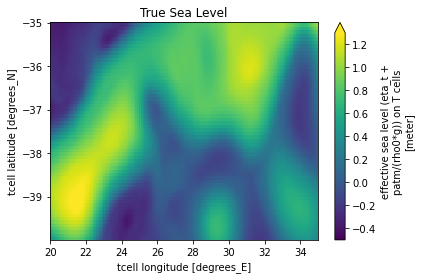

In [3]:
vmin = -0.5
vmax = 1.3
# Plot sea level of selected area
pacific['sea_level'].plot(vmin=vmin, vmax=vmax)
plt.title("True Sea Level")

(63, 150)


Text(0.5, 1.0, 'Sea Level to Train On')

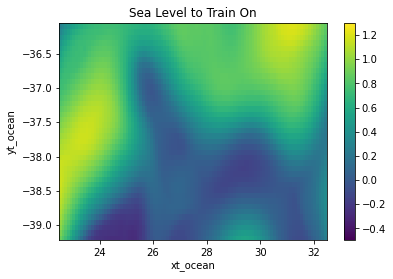

In [4]:
#Select chunk and remove from training data
sea_df = pacific['sea_level'].to_pandas()
print(sea_df.shape)
training_df = sea_df.iloc[10:50, 25:125]
testing_df = sea_df[~sea_df.isin(training_df)]

#Plot Chunk
xr.DataArray(training_df).plot(vmin=vmin, vmax=vmax)
plt.title("Sea Level to Train On")

Text(0.5, 1.0, 'Sea Level to Extrapolate')

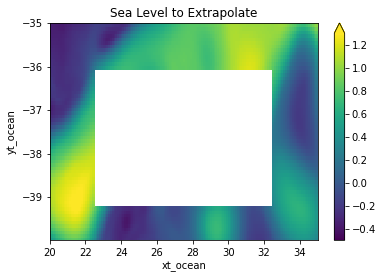

In [5]:
#Plot Training Data
xr.DataArray(testing_df).plot(vmin=vmin, vmax=vmax)
plt.title("Sea Level to Extrapolate")

In [6]:
# Formats sea level data to be compatible with tensor
def format_sea_level(data):
    formatted = []
    for i in range(len(data)):
        formatted.append(data[i])
    
    return torch.FloatTensor((np.array(formatted)).astype(float)).squeeze()

# Convert training and full data to stack format
# & Fill NaN's with Training mean
training = training_df.stack().reset_index()
testing = sea_df.stack().reset_index()

# Set training and testing y's
train_y = format_sea_level(np.array(training[0]))
test_y = format_sea_level(np.array(testing[0]))

In [7]:
# Set training and testing x's
train_x = torch.tensor(np.vstack((training['yt_ocean'], training['xt_ocean'])).T).squeeze()
test_x = torch.tensor(np.vstack((testing['yt_ocean'], testing['xt_ocean'])).T).squeeze()
print(train_x.shape)

torch.Size([4000, 2])


In [8]:
#For plotting purposes only
plot_training = training_df.stack().reset_index()
plot_testing = sea_df[~sea_df.isin(training_df)].fillna(-5).stack().reset_index()

plot_training_y = format_sea_level(np.array(plot_training[0]))
plot_testing_y = format_sea_level(np.array(plot_testing[0]))

plot_training_x = torch.tensor(np.vstack((plot_training['yt_ocean'], plot_training['xt_ocean'])).T).squeeze()
plot_testing_x = torch.tensor(np.vstack((plot_testing['yt_ocean'], plot_testing['xt_ocean'])).T).squeeze()

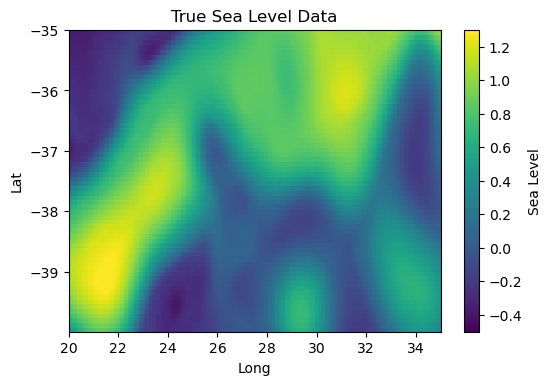

In [9]:
# Plot True Data
test_X_1, test_X_2 = np.meshgrid(test_x[:,1].unique(),test_x[:,0].unique())

plt.figure(dpi=100)
plt.pcolormesh(test_X_1, test_X_2,
             test_y.reshape(test_X_2.shape), vmin=vmin, vmax=vmax, shading='auto')
plt.title("True Sea Level Data")
plt.xlabel("Long")
plt.ylabel("Lat")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Sea Level')
plt.show()

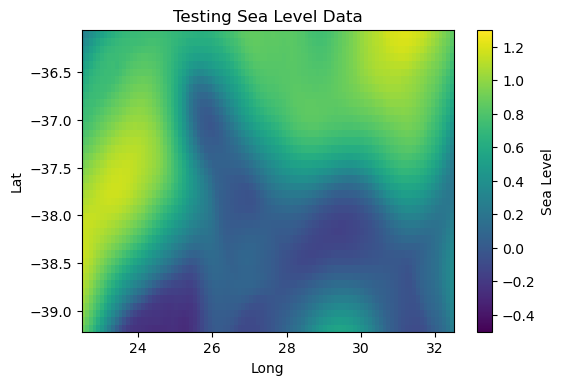

In [10]:
# Plot Training Data
plotting_X_1, plotting_X_2 = np.meshgrid(plot_training_x[:,1].unique(),plot_training_x[:,0].unique())

plt.figure(dpi=100)
plt.pcolormesh(plotting_X_1, plotting_X_2,
             plot_training_y.reshape(plotting_X_2.shape), vmin=vmin, vmax=vmax, shading='auto')
plt.title("Testing Sea Level Data")
plt.xlabel("Long")
plt.ylabel("Lat")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Sea Level')
plt.show()

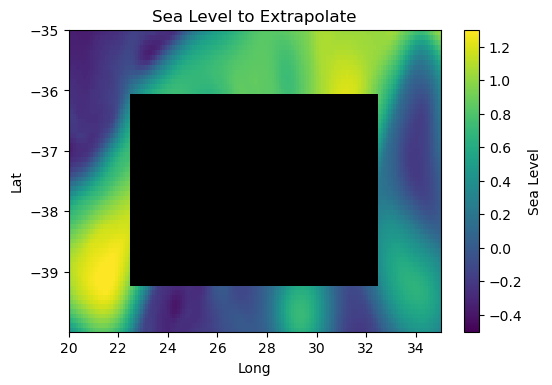

In [11]:
# Plot Extrapolation Chunk
plotting_X_1, plotting_X_2 = np.meshgrid(plot_testing_x[:,1].unique(),plot_testing_x[:,0].unique())

plt.figure(dpi=100)

cmap = copy.copy(plt.cm.get_cmap("viridis"))
cmap.set_under('black')

plt.pcolormesh(plotting_X_1, plotting_X_2,
             plot_testing_y.reshape(plotting_X_2.shape), vmin=vmin, vmax=vmax, shading='auto', cmap=cmap)
plt.title("Sea Level to Extrapolate")
plt.xlabel("Long")
plt.ylabel("Lat")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Sea Level')
plt.show()

Text(0, 0.5, 'Sea Level')

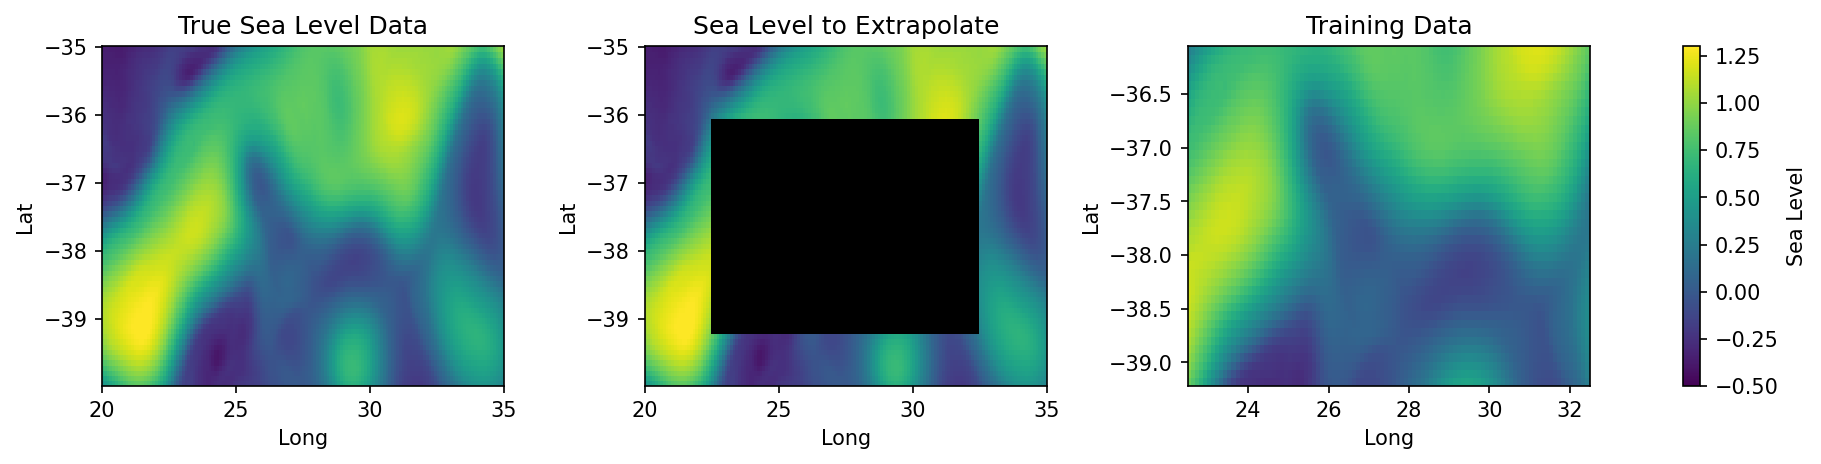

In [12]:
# Plot True Sea Level Data, Sea Level to Extrapolate, and Training Data

test_X_1, test_X_2 = np.meshgrid(test_x[:,1].unique(),test_x[:,0].unique())
plotting_X_1, plotting_X_2 = np.meshgrid(plot_training_x[:,1].unique(),plot_training_x[:,0].unique())
tr_X_1, tr_X_2 = np.meshgrid(plot_testing_x[:,1].unique(),plot_testing_x[:,0].unique())

fig, ax = plt.subplots(1, 3, dpi=150, figsize=(16, 3))
plt.subplots_adjust(wspace = 0.35)

ax[0].pcolormesh(test_X_1, test_X_2,
             test_y.reshape(test_X_2.shape), vmin=vmin, vmax=vmax, shading='auto')
ax[0].set_title("True Sea Level Data")
ax[0].set_xlabel("Long")
ax[0].set_ylabel("Lat")

cmap = copy.copy(plt.cm.get_cmap())
cmap.set_under('black')

ax[1].pcolormesh(tr_X_1, tr_X_2,
             plot_testing_y.detach().reshape(tr_X_2.shape), vmin=vmin, vmax=vmax, cmap=cmap, shading='auto')

ax[1].set_title("Sea Level to Extrapolate")
ax[1].set_xlabel("Long")
ax[1].set_ylabel("Lat")

contour_ = ax[2].pcolormesh(plotting_X_1, plotting_X_2,
             plot_training_y.detach().reshape(plotting_X_2.shape), vmin=vmin, vmax=vmax, shading='auto')
ax[2].set_title("Training Data")
ax[2].set_xlabel("Long")
ax[2].set_ylabel("Lat")


cbar = fig.colorbar(contour_, ax=ax.ravel().tolist())
cbar.ax.set_ylabel('Sea Level')

In [13]:
# Calculate mean std of x and y variables
ytrain_mean = train_y.mean()
ytrain_std = train_y.std()

ytest_mean = test_y.mean()
ytest_std = test_y.std()

# Normalize training data
train_y = ((train_y - train_y.mean()) / train_y.std())

# Normalize testing data
test_y = (test_y - test_y.mean()) / test_y.std()

In [14]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        x_mean = self.mean_module(x)
        x_covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(x_mean, x_covar)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)


hypers = {
    'covar_module.base_kernel.lengthscale': torch.tensor(1.7),
}

model.initialize(**hypers)

print(
    model.covar_module.base_kernel.lengthscale.item(),
)


1.6999999999999997


In [15]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
        
    loss.backward()
#     print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
#         i + 1, training_iter, loss.item(),
#         model.covar_module.base_kernel.lengthscale.item(),
#         model.likelihood.noise.item()
#     ))
    optimizer.step()


/ext3/miniconda3/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


In [16]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

n=9450
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model(test_x))
    train_pred = model(train_x).mean.detach()

pred_labels = observed_pred.mean.view(n)

# Calc abosolute error
delta_y = torch.abs(pred_labels - test_y).detach().numpy()

/ext3/miniconda3/lib/python3.8/site-packages/gpytorch/models/exact_gp.py:273: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(


In [17]:
# Unnormalize Data
train_y = (train_y * ytrain_std) + ytrain_mean
test_y = (test_y * ytest_std) + ytest_mean
train_pred = (train_pred * ytrain_std) + ytrain_mean
pred_labels = (pred_labels * ytrain_std) + ytrain_mean

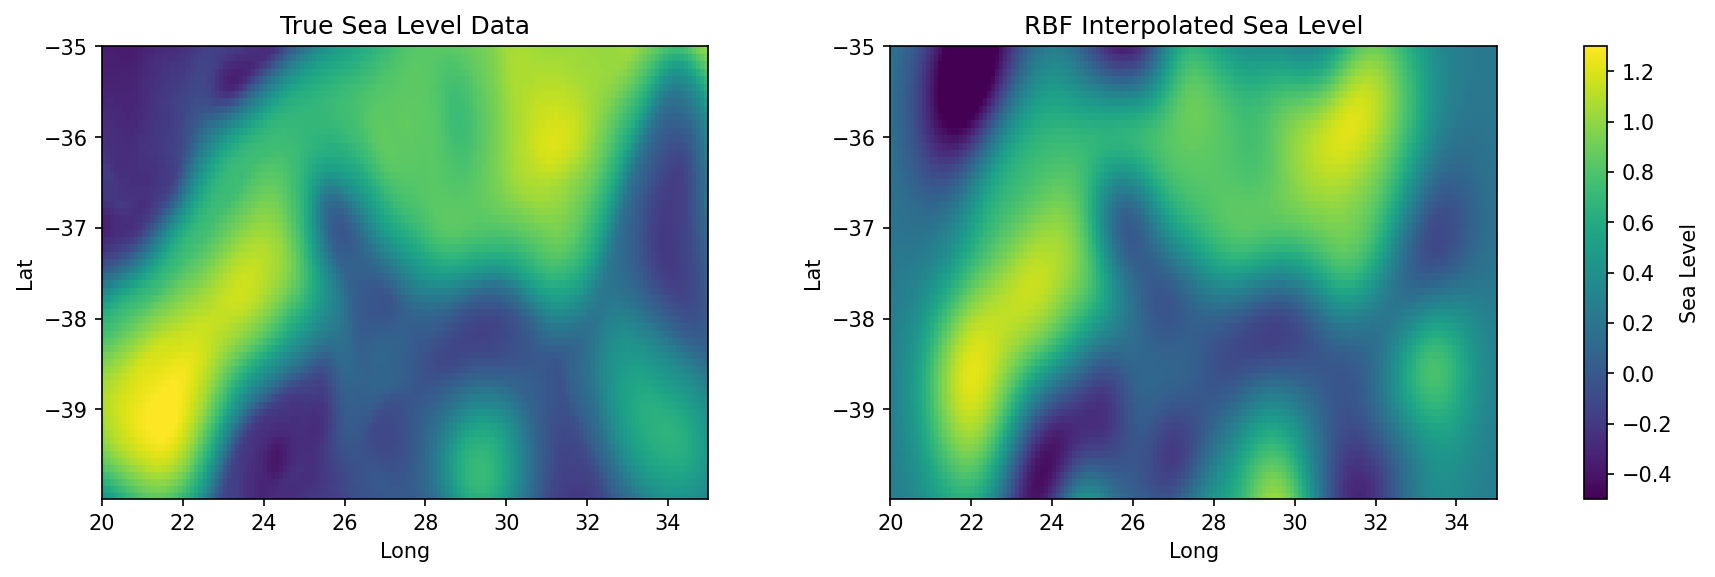

In [18]:
# Plot True Sea Level Data and GP Prediction
test_X_1, test_X_2 = np.meshgrid(test_x[:,1].unique(),test_x[:,0].unique())

fig, ax = plt.subplots(1, 2, dpi=150, figsize=(15, 4))
plt.subplots_adjust(wspace=0.3)

ax[0].pcolormesh(test_X_1, test_X_2,
             test_y.reshape(test_X_2.shape), vmin=vmin, vmax=vmax, shading='auto') 
ax[0].set_title("True Sea Level Data")
ax[0].set_xlabel("Long")
ax[0].set_ylabel("Lat")

contour_ = ax[1].pcolormesh(test_X_1, test_X_2,
             pred_labels.detach().reshape(test_X_2.shape), vmin=vmin, vmax=vmax, shading='auto')
ax[1].set_title("RBF Interpolated Sea Level")
ax[1].set_xlabel("Long")
ax[1].set_ylabel("Lat")
cbar = fig.colorbar(contour_, ax=ax.ravel().tolist())
cbar.ax.set_ylabel('Sea Level')

plt.show()

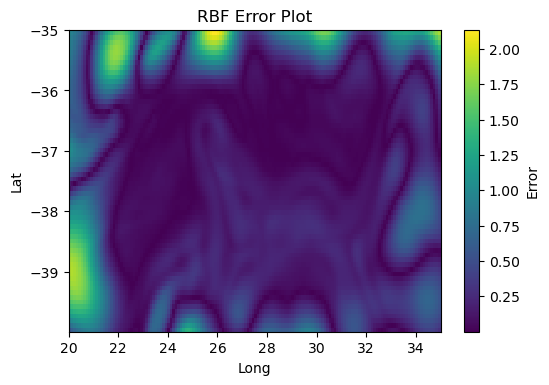

In [19]:
# Plot error
train_X_1, train_X_2 = np.meshgrid(test_x[:,1].unique(),test_x[:,0].unique())

plt.figure(dpi=100, figsize=(6, 4))
plt.pcolormesh(train_X_1, train_X_2,
             delta_y.reshape(train_X_2.shape), shading='auto')
plt.title("RBF Error Plot")
plt.xlabel("Long")
plt.ylabel("Lat")
cbar = plt.colorbar()
cbar.ax.set_ylabel('Error')
plt.show()

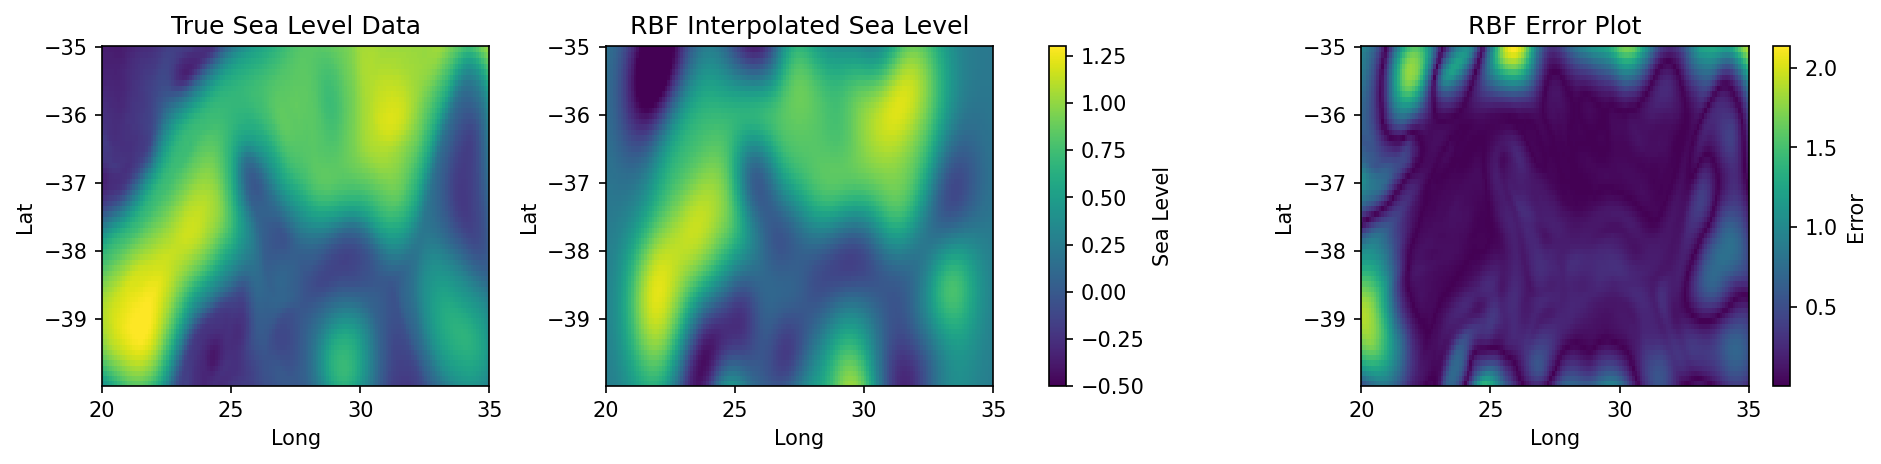

In [20]:
# Plot True Sea Level Data, GP Prediction, and Error
test_X_1, test_X_2 = np.meshgrid(test_x[:,1].unique(),test_x[:,0].unique())

fig, ax = plt.subplots(1, 3, dpi=150, figsize=(15, 3))
plt.subplots_adjust(wspace=0.3)

ax[0].pcolormesh(test_X_1, test_X_2,
             test_y.reshape(test_X_2.shape), vmin=vmin, vmax=vmax, shading='auto') 
ax[0].set_title("True Sea Level Data")
ax[0].set_xlabel("Long")
ax[0].set_ylabel("Lat")

contour_ = ax[1].pcolormesh(test_X_1, test_X_2,
             pred_labels.detach().reshape(test_X_2.shape), vmin=vmin, vmax=vmax, shading='auto')
ax[1].set_title("RBF Extrapolated Sea Level")
ax[1].set_xlabel("Long")
ax[1].set_ylabel("Lat")

error_ = ax[2].pcolormesh(test_X_1, test_X_2,
             delta_y.reshape(test_X_2.shape), shading='auto')
ax[2].set_title("RBF Error Plot")
ax[2].set_xlabel("Long")
ax[2].set_ylabel("Lat")

cbar = fig.colorbar(contour_, ax=ax[0:2].ravel().tolist())
cbar.ax.set_ylabel('Sea Level')

cbar_e = fig.colorbar(error_, ax=ax[2])
cbar_e.ax.set_ylabel('Error')


plt.show()